In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 6.6 MB 8.4 MB/s 
     |████████████████████████████████| 101 kB 2.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 67.0 MB/s 
     |████████████████████████████████| 140 kB 64.5 MB/s 
     |████████████████████████████████| 212 kB 70.9 MB/s 
     |████████████████████████████████| 127 kB 78.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 271 kB 59.1 MB/s 
     |████████████████████████████████| 144 kB 57.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

from google.colab import drive
drive.mount("/google_drive")
WORKSPACE_PATH = "/google_drive/My Drive/MBD Capstone"

xls = pd.ExcelFile(WORKSPACE_PATH+ '/ie_input_data_no_character_sin_no.xlsx')
df = pd.read_excel(xls, 'Sheet1')
df = df[df['idioma'] =='es']
df = df[df['cat_answer'] ==2]

print(len(df))
df.columns = df.columns.str.replace('show_up', 'label')

df = df[["last_answer", "label"]].dropna()
df.columns = df.columns.str.replace('last_answer', 'text')


from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

#Resampling the dataset to balance it
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_trainR, y_trainR = ros.fit_resample(train[['text']], train['label'])
X_testR, y_testR = ros.fit_resample(test[['text']], test['label'])

train = X_trainR.join(y_trainR)
test = X_testR.join(y_testR)

train.to_csv(WORKSPACE_PATH+ '/GUILLE/train.csv')
test.to_csv(WORKSPACE_PATH+ '/GUILLE/test.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


Mounted at /google_drive
476


In [4]:
from datasets import load_dataset, Dataset, DatasetDict

#ds = Dataset.from_pandas(df)
#ds

ds = load_dataset('csv', data_files={'train': WORKSPACE_PATH + '/GUILLE/train.csv', 'test': WORKSPACE_PATH + '/GUILLE/test.csv'})
ds

Using custom data configuration default-8e8697adb63372d3


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8e8697adb63372d3/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 554
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 144
    })
})

In [5]:
from transformers import TFAutoModel
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, BertConfig


import torch
torch.cuda.empty_cache()

model_ckpt = "dccuchile/bert-base-spanish-wwm-cased"
## Torch cuda es solamente un accelerator para paralelizar operaciones (tensors),  que utiliza GPU. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#tf_model = TFAutoModel.from_pretrained(model_ckpt)
#config = BertConfig.from_pretrained(model_ckpt, output_hidden_states=True)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=2)
         .to(device))

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi


Befire training the model, we first  need to tokenize our text. We want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. 


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

text_encoded = ds.map(tokenize, batched=True, batch_size=None)




Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Parameter 'function'=<function tokenize at 0x7f5375e6a440> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Our model expects tensors as inputs, we  will convert the input_ids and attention_mask columns to the "torch" format

In [7]:
text_encoded

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 554
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 144
    })
})

In [8]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [9]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(text_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-NLP-IE-5"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [13]:
from huggingface_hub import notebook_login

notebook_login()

In [14]:
text_encoded["test"]

Dataset({
    features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 144
})

In [15]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=text_encoded["train"],
                  eval_dataset=text_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/Willy/bert-base-spanish-wwm-cased-finetuned-NLP-IE-5 into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697800,0.699261,0.527778
2,0.680800,0.705715,0.534722
3,0.657300,0.696582,0.506944
4,0.627500,0.700823,0.500000
5,0.607500,0.708912,0.506944


In [16]:
preds_output = trainer.predict(text_encoded["test"])
preds_output.metrics

{'test_accuracy': 0.5069444444444444,
 'test_loss': 0.7089118957519531,
 'test_runtime': 1.1224,
 'test_samples_per_second': 128.299,
 'test_steps_per_second': 2.673}

In [17]:
import numpy as np

y_preds = np.argmax(preds_output.predictions, axis=1)

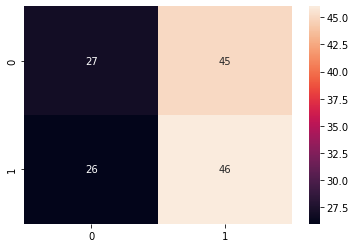

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_valid = np.array(text_encoded["test"]["label"])
cm = confusion_matrix(y_valid, y_preds)
f = sns.heatmap(cm, annot=True, fmt='d')



In [19]:
# Here’s a function that returns the loss along with the predicted label:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [20]:
text_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values

text_encoded["test"] = text_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

text_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = text_encoded["test"][:][cols]
df_test["label"] = df_test["label"]
df_test["predicted_label"] = (df_test["predicted_label"])

  0%|          | 0/9 [00:00<?, ?ba/s]

In [21]:
df_test.sort_values("loss", ascending=True).head(10)
# Mayor LOSS


,text,label,predicted_label,loss
12,,1,1,0.248749
3,"Sí, voy a asistir.",1,1,0.264722
92,confirmo turno,1,1,0.316054
74,Si confirmo,1,1,0.344340
91,"Hola, confirmo presencia en la llamada gracias",1,1,0.354876
35,"Sí, asistiré.",1,1,0.356275
69,"Sí, asistiré.",1,1,0.356275
27,Si Tu respuesta es muy importante para nosotros.,1,1,0.374258
78,Si Tu respuesta es muy importante para nosotros.,1,1,0.374258
93,Hola pía soy el papá de Beni confirmo el turno feliz día del trabajador gracias por el recordatorio,1,1,0.375039


In [23]:
trainer.push_to_hub(commit_message="Beta1")


Upload file runs/Jul07_09-33-14_6c32f1a5d957/events.out.tfevents.1657186516.6c32f1a5d957.71.0:  53%|#####2    …

Upload file runs/Jul07_09-33-14_6c32f1a5d957/1657186516.2014935/events.out.tfevents.1657186516.6c32f1a5d957.71…

To https://huggingface.co/Willy/bert-base-spanish-wwm-cased-finetuned-NLP-IE-5
   c7eea31..0d6f29c  main -> main



'https://huggingface.co/Willy/bert-base-spanish-wwm-cased-finetuned-NLP-IE-5/commit/0d6f29c2771ab088170cfbbaf01d5e780ac8ea40'